# Partitioning Algorithm 
### Estimating $E_0$ and $R_{eco, ref}$ values for the NEE model based on the following equations:
#### Night-time Model ([Reichstein 2005])
#### $$NEE_{night} = R_{eco} = R_{eco,ref}e^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 
#### Day-time Model (Lasslop et al., 2010)
#### $$NEE_{day}=\frac{\alpha \beta R_g}{\alpha R_g + \beta} + \gamma$$


$$NEE = rbe^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 

$$\delta{NEE} = rbe^{(E_0(\frac{1}{T_{ref} - T_0}) - \frac{1}{T - T_0})}$$ 

In [1]:
from IPython.display import display, Math, Latex
import pandas as pd
from tqdm import tqdm
import numpy as np
import scipy
from scipy.stats import normaltest
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Flux Data Loading

In [2]:
flux_data_path = "complete_data.parquet"
flux_data = pd.read_parquet(flux_data_path)

In [3]:
for col in flux_data.columns:
    flux_data[col] = flux_data[col].replace(-9999, np.nan)

In [4]:
flux_data["Date"] = flux_data["DateTime"].dt.date

In [5]:
flux_data['TimeDiff'] = flux_data['DateTime'].diff()
flux_data["dNEE"] = flux_data["NEE"].diff() / flux_data['TimeDiff'].dt.components.minutes
flux_data["dTa"] = flux_data["Ta"].diff() / flux_data['TimeDiff'].dt.components.minutes

In [6]:
flux_data = flux_data.iloc[1:].reset_index(drop=True)

## Night Time Model

In [7]:
night_data = flux_data[flux_data['Day/Night'] == False].reset_index(drop=True)

In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

# Lloyd-Taylor model function
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

# Step 1: Filter the data for night-time conditions
def filter_nighttime_data(df, radiation_threshold=10):
    night_data = df[df['Rg'] < radiation_threshold]
    return night_data

# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def filter_temperature_and_consecutive_periods(night_data, get_seq = False, temperature_column='Ta', min_data_points=6, temperature_range_threshold=5):

    valid_windows = []
    
    # Sort the DataFrame by the Datetime column
    night_data = night_data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    night_data['TimeDiff'] = night_data['DateTime'].diff()
    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    night_data['window_id'] = (night_data['TimeDiff'] > pd.Timedelta(hours=2)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    night_data = night_data.drop(columns=['TimeDiff'])

    for window_id, window in night_data.groupby("window_id"):
        temp_range = window[temperature_column].max() - window[temperature_column].min()
        if temp_range > temperature_range_threshold and len(window) >= min_data_points:
            valid_windows.append(window)

    # Combine all valid windows back into a single DataFrame
    if valid_windows:
        valid_windows_df = pd.concat(valid_windows).reset_index(drop=True)
    else:
        valid_windows_df = pd.DataFrame()

    if get_seq:
        return valid_windows
    return valid_windows_df

def estimate_E0_rb(valid_windows, temperature_column='Ta', reco_column='TER'):
    def objective_function(T, Reco_ref, E0):
        return lloyd_taylor(T, Reco_ref, E0)
    
    # Store the regression results
    regression_results = []

    output = valid_windows.copy()
    output["E0"] = np.zeros(output.shape[0])
    output["rb"] = np.zeros(output.shape[0])
    
    # Perform regression for each valid period
    for window_id, window in valid_windows.groupby('window_id'):
        popt, pcov = curve_fit(objective_function, window[temperature_column], window[reco_column], bounds = [(0, 50), (1100, 400)], maxfev=10000)
        Reco_ref, E0 = popt
        output.loc[output["window_id"] == window_id, "E0"] = E0
        output.loc[output["window_id"] == window_id, "rb"] = Reco_ref
    return output


In [9]:
night_data = filter_nighttime_data(night_data)
valid_windows = filter_temperature_and_consecutive_periods(night_data)

output = estimate_E0_rb(valid_windows)
output

,DateTime,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,...,Eq of Time (minutes),HA Sunrise (deg),Solar Noon (LST),Sunrise Time (LST),Sunset Time (LST),dNEE,dTa,window_id,E0,rb
0,2012-06-25 20:30:00,NaN,1.57750,NaN,1.42650,NaN,0.60751,0.002056,0.000273,0.81880,...,-2.808584,90.907335,12:02:48.515000,05:59:10.755000,18:06:26.275000,NaN,-0.040667,4,195.469618,3.678643
1,2012-06-25 21:00:00,NaN,5.37180,NaN,0.86045,-12.531,2.58480,0.010224,0.001435,0.95576,...,-2.812959,90.907330,12:02:48.778000,05:59:11.018000,18:06:26.537000,NaN,-0.041333,4,195.469618,3.678643
2,2012-06-25 21:30:00,NaN,4.31370,NaN,1.08790,NaN,1.64920,0.009996,0.000891,1.08540,...,-2.817334,90.907325,12:02:49.040000,05:59:11.282000,18:06:26.798000,NaN,-0.037000,4,195.469618,3.678643
3,2012-06-25 22:00:00,NaN,3.00040,NaN,1.22250,NaN,0.85372,0.009655,0.000799,-0.12649,...,-2.821707,90.907320,12:02:49.302000,05:59:11.546000,18:06:27.059000,NaN,-0.001667,4,195.469618,3.678643
4,2012-06-25 22:30:00,NaN,1.50370,NaN,0.80781,NaN,0.76351,0.017135,0.001497,-1.87090,...,-2.826079,90.907315,12:02:49.565000,05:59:11.809000,18:06:27.320000,NaN,0.006667,4,195.469618,3.678643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20304,2019-12-12 03:30:00,NaN,15.52400,NaN,NaN,-14.946,1.24400,0.039700,0.003870,2.92510,...,6.574835,90.905226,11:53:25.510000,05:49:48.256000,17:57:02.764000,NaN,0.000000,2729,71.593923,1.146169
20305,2019-12-12 04:00:00,NaN,4.09720,NaN,NaN,-11.102,0.97781,0.030800,0.002630,4.30950,...,6.565189,90.905237,11:53:26.089000,05:49:48.832000,17:57:03.345000,NaN,-0.003333,2729,71.593923,1.146169
20306,2019-12-12 04:30:00,NaN,0.77137,-2.0148,1.84490,-15.294,1.43420,0.040400,0.003020,0.46467,...,6.555542,90.905248,11:53:26.668000,05:49:49.408000,17:57:03.927000,NaN,-0.004667,2729,71.593923,1.146169
20307,2019-12-12 05:00:00,1.64760,0.27336,-4.6968,1.25880,-17.475,1.28700,0.034400,0.002910,0.06990,...,6.545891,90.905259,11:53:27.247000,05:49:49.984000,17:57:04.509000,NaN,0.008333,2729,71.593923,1.146169


In [10]:
year_data = output.loc[(output["DateTime"] < "01-01-2020") & (output["DateTime"] >= "01-01-2019")]

In [11]:
np.mean(year_data["E0"]), np.std(year_data["E0"])

(96.63058411886534, 29.147855805229234)

In [12]:
np.mean(year_data["rb"]), np.std(year_data["rb"])

(4.920935696959301, 2.6511490488079295)

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_19133/1619282018.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(year_data["E0"])


<Axes: xlabel='E0', ylabel='Density'>

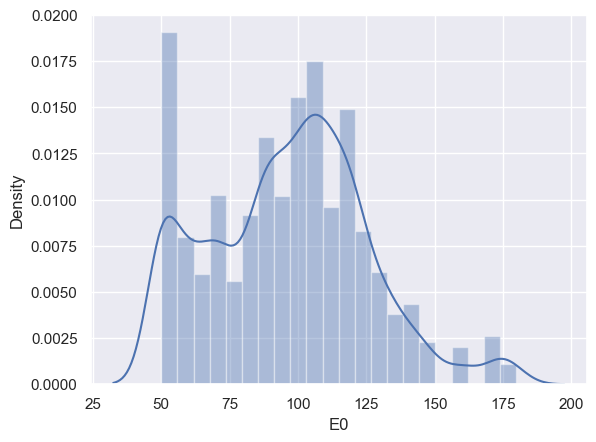

In [13]:
sns.distplot(year_data["E0"])

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_19133/3626743820.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(year_data["rb"])


<Axes: xlabel='rb', ylabel='Density'>

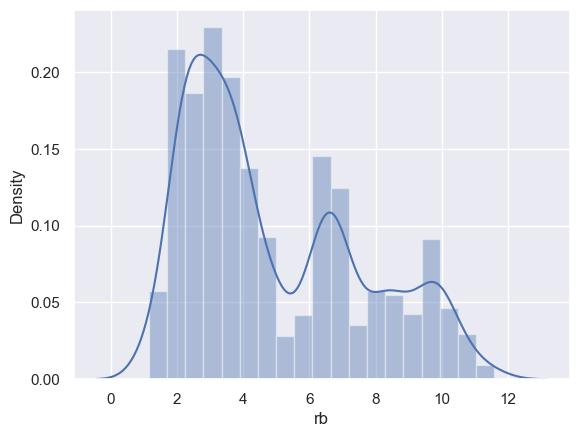

In [14]:
sns.distplot(year_data["rb"])

0.09877656310659283
0.9975568382633928


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_19133/3238413628.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(year_data["TER"].values - y)
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_19133/3238413628.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(year_data["

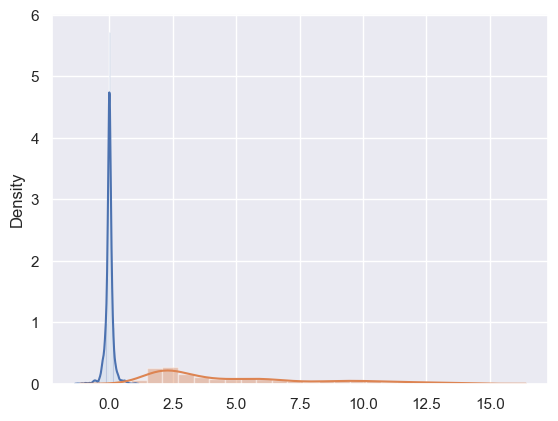

In [15]:
y = lloyd_taylor(year_data["Ta"], year_data["rb"], year_data["E0"]).values
print(np.mean(np.abs(year_data["TER"].values - y)))
sns.distplot(year_data["TER"].values - y)
sns.distplot(year_data["TER"].values)
print(r2_score(year_data["TER"].values, y))

### Combining E0 and Rb with complete night data. We use ffill to fill missing E0 and rb from data filtered out earleir of >10 Rg

In [16]:
common_columns = night_data.columns.intersection(output.columns).tolist()
common_columns.remove('DateTime')

In [17]:
final_night_data = pd.merge(night_data, output.drop(columns=common_columns), how="left", on="DateTime")

In [18]:
final_night_data[final_night_data["E0"].notna()]["E0"][60:]

239      134.827031
240      134.827031
241      134.827031
307      123.622717
308      123.622717
            ...    
58640     71.593923
58641     71.593923
58642     71.593923
58643     71.593923
58644     71.593923
Name: E0, Length: 20249, dtype: float64

In [19]:
final_night_data["E0"] = final_night_data["E0"].fillna(method="ffill").fillna(method="bfill")
final_night_data["rb"] = final_night_data["rb"].fillna(method="ffill").fillna(method="bfill")

In [20]:
final_night_data.to_parquet("final_night_data.parquet")

## Daytime Model

In [276]:
day_data = flux_data[flux_data['Day/Night'] == True].reset_index(drop=True)

In [277]:
day_data = day_data.dropna(subset=["Rg"]).reset_index(drop=True)

In [278]:
day_data["E0"] = np.zeros(day_data.shape[0])

for date, indices in tqdm(day_data.groupby("Date").indices.items()):
    e0 = final_night_data["E0"][final_night_data["Date"] == date].values[0]
    day_data.loc[indices, "E0"] = e0
    
    

100%|██████████████████████████████████████████████████████████| 2733/2733 [00:03<00:00, 727.41it/s]


In [287]:
def lloyd_taylor(T, Reco_ref, E0):
    T_ref = 10  # Reference temperature (°C)
    return Reco_ref * np.exp(E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02))))

def lloyd_taylor_rb(Reco, T, E0):
    T_ref = 10
    return Reco * np.exp(- (E0 * ((1 / (T_ref + 46.02)) - (1 / (T + 46.02)))))
    

# Light-response curve function for GPP
def light_response_curve(PAR, alpha, beta):
    return (alpha * beta * PAR) / (alpha * PAR + beta)

def fit_light_response_curve_GPP(day_data, PAR_column='Rg', gpp_column='GEP', temperature_column='Ta'):

    # Store the regression results
    regression_results = []

    output = day_data.copy()
    output["alpha"] = np.zeros(output.shape[0])
    output["beta"] = np.zeros(output.shape[0])

    regression_results = []
    # Perform regression for each valid period
    for window_id, window in day_data.groupby('window_id'):
                    
        popt, _ = curve_fit(light_response_curve, window[PAR_column], window[gpp_column], bounds = [(0, 0), (0.22, 250)], maxfev=10000)
        alpha, beta  = popt

        # Calculate residuals
        residuals = window[gpp_column] - light_response_curve(window[PAR_column], alpha, beta)
        residual_sum_of_squares = np.sum(residuals**2)
        
        regression_results.append((alpha, beta, window_id, residual_sum_of_squares))
        
        output.loc[output["window_id"] == window_id, "alpha"] = alpha
        output.loc[output["window_id"] == window_id, "beta"] = beta

    return output

# Step 2: Split data into consecutive periods and filter based on temperature range and data points
def generate_day_sequences(data, get_seq = False):
    
    # Sort the DataFrame by the Datetime column
    data = data.sort_values('DateTime')
    # Calculate the time difference between consecutive rows
    data['TimeDiff'] = data['DateTime'].diff()

    # Define a new sequence ID that increments every time the time difference exceeds 1 hour
    data['window_id'] = (data['TimeDiff'] > pd.Timedelta(hours=4)).cumsum()
    # Drop the TimeDiff column as it's no longer needed (optional)
    data = data.drop(columns=['TimeDiff'])

    return data



In [285]:
valid_windows = generate_day_sequences(day_data)
# Step 2: Fit the light-response curve for day-time data
output = fit_light_response_curve_GPP(valid_windows)

In [286]:
output

,DateTime,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,...,var y,Eq of Time (minutes),HA Sunrise (deg),Solar Noon (LST),Sunrise Time (LST),Sunset Time (LST),E0,window_id,alpha,beta
0,2012-06-22 06:00:00,6.4539,1.63140,87.030,9.32060,19.8800,2.42790,0.21715,0.013563,-0.290640,...,0.043020,-2.038826,90.907860,12:02:02.330000,05:58:24.443000,18:05:40.216000,195.469618,0,3.665269e-13,1.330226e-09
1,2012-06-22 06:30:00,5.5680,0.18280,97.393,3.81670,13.8530,1.16120,0.23361,0.012930,-0.083710,...,0.043020,-2.043331,90.907858,12:02:02.600000,05:58:24.714000,18:05:40.486000,195.469618,0,3.665269e-13,1.330226e-09
2,2012-06-22 07:00:00,4.8914,0.35831,135.540,6.00190,28.2090,4.08820,0.22873,0.013813,-0.043682,...,0.043020,-2.047836,90.907857,12:02:02.870000,05:58:24.984000,18:05:40.756000,195.469618,0,3.665269e-13,1.330226e-09
3,2012-06-22 07:30:00,5.1051,0.24332,166.290,8.95920,22.3040,2.31180,0.26517,0.016773,-0.044093,...,0.043020,-2.052341,90.907856,12:02:03.140000,05:58:25.255000,18:05:41.026000,195.469618,0,3.665269e-13,1.330226e-09
4,2012-06-22 08:00:00,3.5807,1.33500,129.660,16.24900,-4.5913,1.89220,0.25665,0.015298,0.289860,...,0.043020,-2.056845,90.907854,12:02:03.411000,05:58:25.526000,18:05:41.296000,195.469618,0,3.665269e-13,1.330226e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64480,2019-12-31 16:00:00,NaN,0.10695,NaN,1.22710,NaN,1.24720,0.01470,0.001200,0.083800,...,0.043016,-2.928449,90.905495,12:02:55.707000,05:59:18.388000,18:06:33.026000,71.593923,2766,8.030925e-18,2.215540e-14
64481,2019-12-31 16:30:00,NaN,0.06780,NaN,0.57368,NaN,0.77800,0.00688,0.000429,0.097900,...,0.043016,-2.938367,90.905484,12:02:56.302000,05:59:18.986000,18:06:33.618000,71.593923,2766,8.030925e-18,2.215540e-14
64482,2019-12-31 17:00:00,NaN,0.19298,NaN,0.34905,NaN,0.76512,0.00200,0.000273,0.180620,...,0.043016,-2.948284,90.905474,12:02:56.897000,05:59:19.583000,18:06:34.211000,71.593923,2766,8.030925e-18,2.215540e-14
64483,2019-12-31 17:30:00,NaN,0.35412,NaN,0.50104,NaN,1.63450,0.01180,0.001090,-0.093600,...,0.043016,-2.958198,90.905464,12:02:57.492000,05:59:20.181000,18:06:34.803000,71.593923,2766,8.030925e-18,2.215540e-14


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_79014/3056107999.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["alpha"])


<Axes: xlabel='alpha', ylabel='Density'>

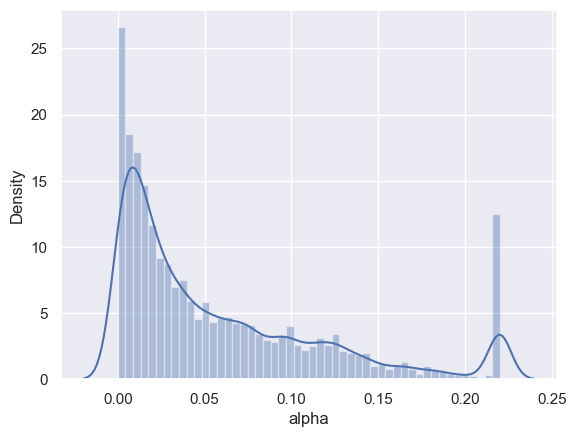

In [289]:
sns.distplot(output["alpha"])

/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_79014/2265527681.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["beta"])


<Axes: xlabel='beta', ylabel='Density'>

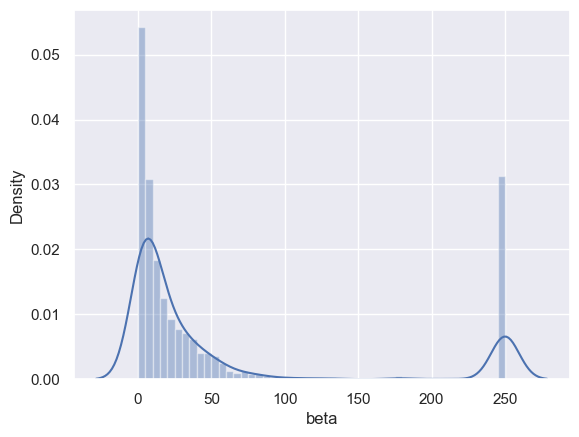

In [290]:
sns.distplot(output["beta"])

In [303]:
rb = output[["TER", "Ta", "E0"]].apply(lambda x: lloyd_taylor_rb(x[0], x[1], x[2]), axis=1)
output["rb"] = rb

In [304]:
output

,DateTime,NEE,NEE_unc,LE,LE_unc,H,H_unc,Tau,Tau_unc,CO2_strg,...,Eq of Time (minutes),HA Sunrise (deg),Solar Noon (LST),Sunrise Time (LST),Sunset Time (LST),E0,window_id,alpha,beta,rb
0,2012-06-22 06:00:00,6.4539,1.63140,87.030,9.32060,19.8800,2.42790,0.21715,0.013563,-0.290640,...,-2.038826,90.907860,12:02:02.330000,05:58:24.443000,18:05:40.216000,195.469618,0,3.665269e-13,1.330226e-09,3.870102
1,2012-06-22 06:30:00,5.5680,0.18280,97.393,3.81670,13.8530,1.16120,0.23361,0.012930,-0.083710,...,-2.043331,90.907858,12:02:02.600000,05:58:24.714000,18:05:40.486000,195.469618,0,3.665269e-13,1.330226e-09,3.835987
2,2012-06-22 07:00:00,4.8914,0.35831,135.540,6.00190,28.2090,4.08820,0.22873,0.013813,-0.043682,...,-2.047836,90.907857,12:02:02.870000,05:58:24.984000,18:05:40.756000,195.469618,0,3.665269e-13,1.330226e-09,3.931900
3,2012-06-22 07:30:00,5.1051,0.24332,166.290,8.95920,22.3040,2.31180,0.26517,0.016773,-0.044093,...,-2.052341,90.907856,12:02:03.140000,05:58:25.255000,18:05:41.026000,195.469618,0,3.665269e-13,1.330226e-09,3.851381
4,2012-06-22 08:00:00,3.5807,1.33500,129.660,16.24900,-4.5913,1.89220,0.25665,0.015298,0.289860,...,-2.056845,90.907854,12:02:03.411000,05:58:25.526000,18:05:41.296000,195.469618,0,3.665269e-13,1.330226e-09,3.771106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64480,2019-12-31 16:00:00,NaN,0.10695,NaN,1.22710,NaN,1.24720,0.01470,0.001200,0.083800,...,-2.928449,90.905495,12:02:55.707000,05:59:18.388000,18:06:33.026000,71.593923,2766,8.030925e-18,2.215540e-14,0.808899
64481,2019-12-31 16:30:00,NaN,0.06780,NaN,0.57368,NaN,0.77800,0.00688,0.000429,0.097900,...,-2.938367,90.905484,12:02:56.302000,05:59:18.986000,18:06:33.618000,71.593923,2766,8.030925e-18,2.215540e-14,0.828685
64482,2019-12-31 17:00:00,NaN,0.19298,NaN,0.34905,NaN,0.76512,0.00200,0.000273,0.180620,...,-2.948284,90.905474,12:02:56.897000,05:59:19.583000,18:06:34.211000,71.593923,2766,8.030925e-18,2.215540e-14,0.830424
64483,2019-12-31 17:30:00,NaN,0.35412,NaN,0.50104,NaN,1.63450,0.01180,0.001090,-0.093600,...,-2.958198,90.905464,12:02:57.492000,05:59:20.181000,18:06:34.803000,71.593923,2766,8.030925e-18,2.215540e-14,0.821418


/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_79014/1551583255.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(final_night_data["NEE_filled"])
/var/folders/7r/b0750y3s1vq7yqj7x8mjxc3m0000gn/T/ipykernel_79014/1551583255.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(output["

<Axes: xlabel='NEE_filled', ylabel='Density'>

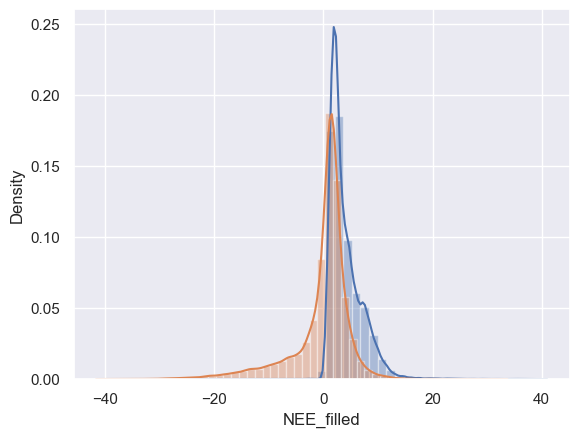

In [307]:
sns.distplot(final_night_data["NEE_filled"])
sns.distplot(output["NEE_filled"])

In [309]:
normaltest(final_night_data["NEE_filled"])

NormaltestResult(statistic=26336.791789336974, pvalue=0.0)

In [310]:
normaltest(output["NEE_filled"])

NormaltestResult(statistic=25401.81570351349, pvalue=0.0)

In [312]:
output.to_parquet("final_day_data.parquet")